In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from difflib import SequenceMatcher
import re

**1. QS World Ranking website scrapping**

In [2]:
url = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508196855735"
#Doing http request to get the text file
response = requests.get(url)
if response.status_code == 200:
    print("Success")
else:
    print("Failure")

Success


In [3]:
#Use beautifulSoup to extract the data
results_page = BeautifulSoup(response.content.decode("utf-8", errors='ignore'),'html.parser')
data_string=str(results_page)


In [4]:
def cleanhtml(raw_html):
    """
    make easier parsable html
    """
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext
l=cleanhtml(str(data_string))
m=json.dumps(l)
n=json.loads(m )



In [5]:
#load the json files and make a dataframe
k=json.loads(n)
df = pd.DataFrame.from_dict(json_normalize(k["data"][:]), orient='columns')

Unfortunatly there is some missing data that we should look up on the page of the university itself.
We look in the html file with the help of beautifulSoup. 

In [6]:
#Drop useless columns
df=df.drop(['guide','logo','core_id','nid','cc','stars'],axis=1)
#Add the columns in which we are going to fill in the data
df=pd.concat([df,pd.DataFrame(columns=['totalStaff','internationalStaff','totalStudents','internationalStudents'])])
baseurl='https://www.topuniversities.com'
#Extract the number from the div class
def extractNumber(div):
    return div.find('div',class_="number").text.strip()
#Get the missing data from each URL. The missing data is: total staff, 
#total international staff, total students, total international students
for index,path in enumerate(df['url']):
    
    f=df["rank_display"].iloc[index]
    f=f.replace("=","")
    f=f.split("-")[0]
    #Get the top 200     
    if int(f)>200: 
        indexFinal=index
        df=df.iloc[0:indexFinal]
        break

    #Retrieve html
    response = requests.get(baseurl+path)
    if response.status_code == 200:
        #Create a html parser
        soup=BeautifulSoup(response.content,'html.parser')
        try:
            #find the class total faculty in which we can extract the usefull number.
            mydivs = soup.find_all("div", { "class" : "total faculty" })
            df['totalStaff'].iloc[index]=extractNumber(mydivs[0])
        except IndexError:
            print('missing total staff:  '+str(baseurl+path))
        
        
        
        try:
            mydivs = soup.find_all("div", { "class" : "inter faculty" })
            df['internationalStaff'].iloc[index]=extractNumber(mydivs[0])
        except IndexError:
            print('missing international staff '+str(baseurl+path))

        try:
            mydivs=soup.find_all("div", { "class" : "students-main wrapper col-md-4" })
            df['totalStudents'].iloc[index]=extractNumber(mydivs[0])
        except IndexError:
            print('missing total students:   '+str(baseurl+path))



        try:
            mydivs=soup.find_all("div", { "class" : "int-students-main wrapper col-md-4" })
            df['internationalStudents'].iloc[index]=extractNumber(mydivs[0])
        except IndexError:
            print('missing international students: '+str(baseurl+path))
        
            

        
    else:
        print("Failure")
        
dfFirst=df.copy()

missing total staff:  https://www.topuniversities.com/universities/new-york-university-nyu
missing international staff https://www.topuniversities.com/universities/new-york-university-nyu
missing total students:   https://www.topuniversities.com/universities/new-york-university-nyu
missing international students: https://www.topuniversities.com/universities/new-york-university-nyu
missing international staff https://www.topuniversities.com/universities/indian-institute-science-iisc-bangalore


In [7]:
df=dfFirst.copy()#Starting of with a clean data frame, for debugging purposes

In [8]:
#Cleaning the numbers
col_list=['internationalStaff','internationalStudents','totalStaff','totalStudents']
df[col_list]=df[col_list].apply(lambda x: x.str.replace(',',''))
df[col_list]=df[col_list].astype(float)

<b>Which are the best universities in term of:(a) ratio between faculty members and students (b) ratio of international students?</b></b>

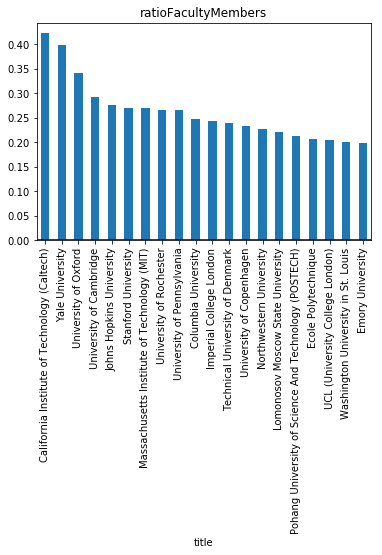

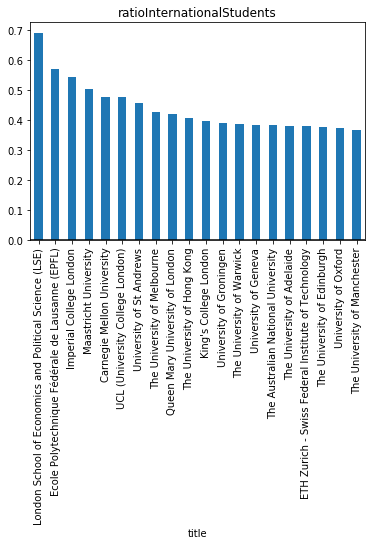

In [9]:
#Getting ratio between faculty members
plt.close()
plt.figure()
df['ratioFacultyMembers']=np.array(df['totalStaff'])/np.array(df['totalStudents'])
dfSortedFacultyMembers=df.sort_values('ratioFacultyMembers',ascending=False).head(20)
s = pd.Series(dfSortedFacultyMembers['ratioFacultyMembers'].values, index=dfSortedFacultyMembers['title'])
s.plot(kind='bar');
plt.axhline(0, color='k')
plt.title('ratioFacultyMembers')
plt.show()

#Getting ratio between international students
df['ratioInternationalStudents']=np.array(df.internationalStudents)/np.array(df.totalStudents)
dfSortedInternationalStudents=df.sort_values('ratioInternationalStudents',ascending=False).head(20)
s = pd.Series(dfSortedInternationalStudents['ratioInternationalStudents'].values, index=dfSortedInternationalStudents['title'])
s.plot(kind='bar');
plt.axhline(0, color='k')
plt.title('ratioInternationalStudents')
plt.show()



<b>Answer the previous question aggregating the data by (c) country</b>

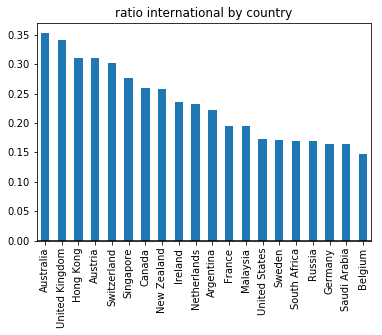

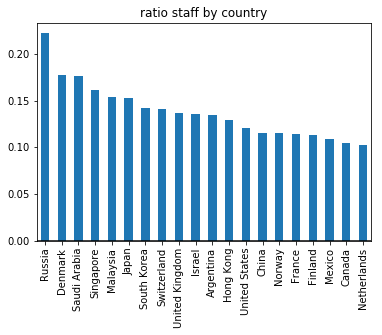

In [10]:
#aggregating by country
countryDict={}

#Iterating over each country. groupDff is the dataframe of the country
for country,groupDff in df.groupby('country'):
    groupDf=groupDff.dropna(axis=0,how='any')
    staff=np.sum(np.array(groupDf['totalStaff']))/np.sum(np.array(groupDf['totalStudents']))
    international=np.sum(np.array(groupDf['internationalStudents']))/np.sum(np.array(groupDf['totalStudents']))
    countryDict[country]=[staff,international]
#plotting it in the same way as before
t=np.array(list(countryDict.values()))[:,1]
s=pd.Series(t,list(countryDict.keys()))
s=s.sort_values(ascending=False).head(20)
s.plot(kind='bar');
plt.axhline(0, color='k')
plt.title('ratio international by country')
plt.show()

#plotting it the same way as before
t=np.array(list(countryDict.values()))[:,0]
s=pd.Series(t,list(countryDict.keys()))
s=s.sort_values(ascending=False).head(20)
s.plot(kind='bar');
plt.axhline(0, color='k')
plt.title('ratio staff by country')
plt.show()






<b>Answer the previous question aggregating the data by (d) region</b>

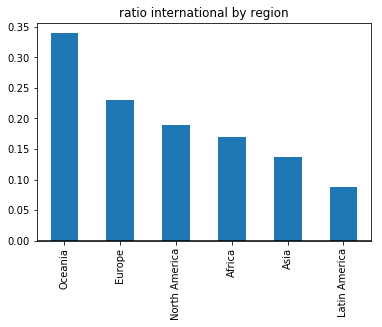

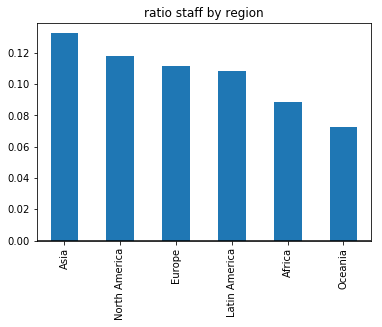

In [11]:
#Aggregating by region
regionDict={}
#Analog to country
for region,groupDff in df.groupby('region'):
    groupDf=groupDff.dropna(axis=0,how='any')
    staff=np.sum(np.array(groupDf['totalStaff']))/np.sum(np.array(groupDf['totalStudents']))
    international=np.sum(np.array(groupDf['internationalStudents']))/np.sum(np.array(groupDf['totalStudents']))
    regionDict[region]=[staff,international]

#plotting it in the same way as before
t=np.array(list(regionDict.values()))[:,1]
s=pd.Series(t,list(regionDict.keys()))
s=s.sort_values(ascending=False)
s.plot(kind='bar');
plt.axhline(0, color='k')
plt.title('ratio international by region')
plt.show()


t=np.array(list(regionDict.values()))[:,0]
s=pd.Series(t,list(regionDict.keys()))
s=s.sort_values(ascending=False)
s.plot(kind='bar');
plt.axhline(0, color='k')
plt.title('ratio staff by region')
plt.show()



**2. Times Higher Education website scrapping**

In [12]:
#Wget the information from the url
url = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"
response = requests.get(url)
if response.status_code == 200:
    print("Success")
else:
    print("Failure")

Success


In [13]:
#Analog to first exercise
results_page = BeautifulSoup(response.content.decode("utf-8", errors='ignore'),'html.parser')
data_string=str(results_page)

In [14]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext
l=cleanhtml(str(data_string))
m=json.dumps(l)
n=json.loads(m )



In [15]:
#Output to DataFrame
k=json.loads(n)

dfTh = pd.DataFrame.from_dict(json_normalize(k["data"][:]), orient='columns')

In [16]:
#Cleaning up the DataFrame
dfTh = dfTh[['location','name','rank','stats_number_students','stats_student_staff_ratio','stats_pc_intl_students']].copy()

dfTh['rank']=dfTh['rank'].astype(str)
#Get the top 200
for index,f in enumerate(dfTh['rank']):
    f=f.replace("=","")
    f=f.split("–")[0]
    #Get the top 200 
    if int(f)>200: 
        indexFinal=index
        break

dfTh=dfTh.iloc[0:indexFinal]
#Remove komma's
dfTh['stats_number_students']=dfTh['stats_number_students'].apply(lambda x: x.replace(',',''))
dfTh['stats_number_students']=dfTh['stats_number_students'].astype(float)

<b>Which are the best universities in term of:(a) ratio between faculty members and students (b) ratio of international students?</b></b>

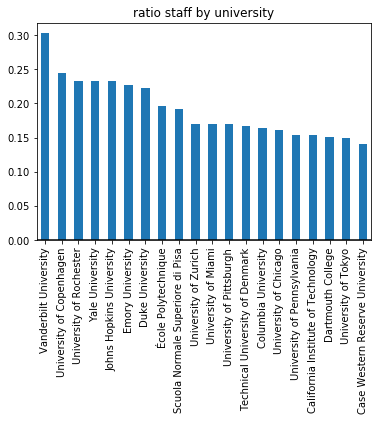

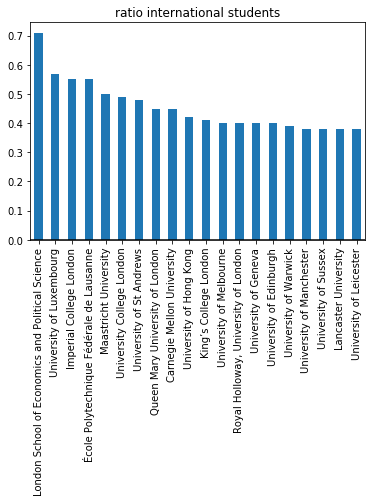

In [17]:
#student staff ratio per university
ratios=1/np.array(dfTh.stats_student_staff_ratio.astype(float))
seriesStaffStudent=pd.Series(ratios,dfTh.name.values)
#Get the top 20
seriesStaffStudent=seriesStaffStudent.sort_values(ascending=False).head(20)
plt.figure()
seriesStaffStudent.plot(kind='bar');
plt.axhline(0, color='k')
plt.title('ratio staff by university')



dfTh.stats_pc_intl_students=dfTh.stats_pc_intl_students.astype(str).str.replace("%","")
dfTh.stats_pc_intl_students=dfTh.stats_pc_intl_students.astype(float)/100
seriesInternationalStudents=pd.Series(dfTh.stats_pc_intl_students.values,dfTh.name.values)
#Get the top 20
seriesInternationalStudents=seriesInternationalStudents.sort_values(ascending=False).head(20)

plt.figure()
seriesInternationalStudents.plot(kind='bar');
plt.axhline(0, color='k')
plt.title('ratio international students')
plt.show()



<b>Answer the previous question aggregating the data by (c) country</b>

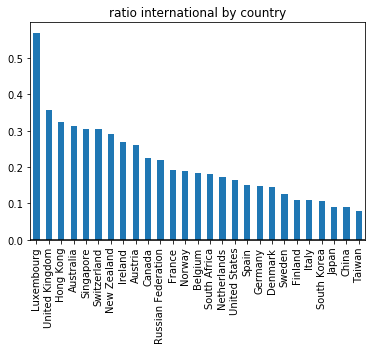

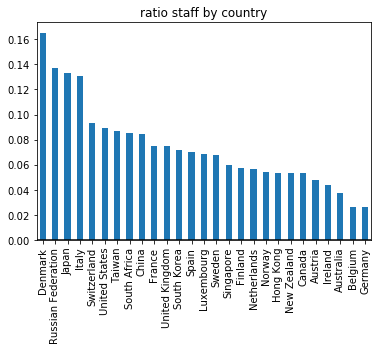

In [18]:
#Aggregating by country

countryDict={}
#Analog to previous exercise
for country,groupDff in dfTh.groupby('location'):
    groupDf=groupDff.dropna(axis=0,how='any')
    students=np.array(groupDf.stats_number_students).astype(float)
    staff=students/np.array(groupDf.stats_student_staff_ratio).astype(float)
    staffRatio=np.sum(staff)/np.sum(students)
    international=students*np.array(groupDf.stats_pc_intl_students).astype(float)
    internationalRatio=np.sum(international)/np.sum(students)
    countryDict[country]=[staffRatio,internationalRatio]
#plotting it in the same way as before
t=np.array(list(countryDict.values()))[:,1]
s=pd.Series(t,list(countryDict.keys()))
s=s.sort_values(ascending=False)
s.plot(kind='bar');
plt.axhline(0, color='k')
plt.title('ratio international by country')
plt.show()


t=np.array(list(countryDict.values()))[:,0]
s=pd.Series(t,list(countryDict.keys()))
s=s.sort_values(ascending=False)
s.plot(kind='bar');
plt.axhline(0, color='k')
plt.title('ratio staff by country')
plt.show()   



<b>Answer the previous question aggregating the data by (d) country</b>

In [19]:
#Creating the regions
#Unfortunatly the information is not in this data frame
#Get the information from the other dataframe
dfTh["region"]=np.nan
pd.options.mode.chained_assignment = None  # default='warn'

#Matching with other dataframe
for index,location in enumerate(dfTh["location"]):
    try:
        region=dfFirst[dfFirst["country"]==location].region.values[0]
        dfTh["region"].iloc[index]=region
    except (ValueError,IndexError):
        print("could not find region for; "+str(location))
        if location=="Russian Federation":
            dfTh.region.iloc[index]="Europe"
        elif location=="Luxembourg":
            dfTh.region.iloc[index]="Europe"
            
    

could not find region for; Luxembourg
could not find region for; Russian Federation


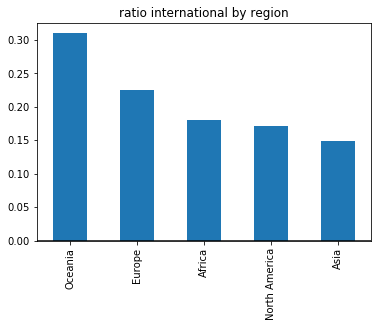

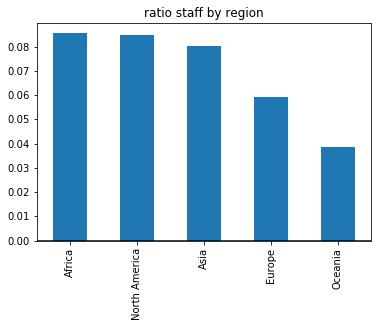

In [20]:
#plotting the region 
regionDict={}
for region,groupDff in dfTh.groupby('region'):
    groupDf=groupDff.dropna(axis=0,how='any')
    
    students=np.array(groupDf.stats_number_students).astype(float)
    staff=students/np.array(groupDf.stats_student_staff_ratio).astype(float)
    staffRatio=np.sum(staff)/np.sum(students)
    international=students*np.array(groupDf.stats_pc_intl_students).astype(float)
    internationalRatio=np.sum(international)/np.sum(students)
    regionDict[region]=[staffRatio,internationalRatio]

#plotting it in the same way as before
t=np.array(list(regionDict.values()))[:,1]
s=pd.Series(t,list(regionDict.keys()))
s=s.sort_values(ascending=False)
s.plot(kind='bar');
plt.axhline(0, color='k')
plt.title('ratio international by region')
plt.show()


t=np.array(list(regionDict.values()))[:,0]
s=pd.Series(t,list(regionDict.keys()))
s=s.sort_values(ascending=False)
s.plot(kind='bar');
plt.axhline(0, color='k')
plt.title('ratio staff by region')
plt.show()




**3. Merging Data Frames**

In [21]:
dfTh

,location,name,rank,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students,region
0,United Kingdom,University of Oxford,1,20409.0,11.2,0.38,Europe
1,United Kingdom,University of Cambridge,2,18389.0,10.9,0.35,Europe
2,United States,California Institute of Technology,=3,2209.0,6.5,0.27,North America
3,United States,Stanford University,=3,15845.0,7.5,0.22,North America
4,United States,Massachusetts Institute of Technology,5,11177.0,8.7,0.34,North America
5,United States,Harvard University,6,20326.0,8.9,0.26,North America
6,United States,Princeton University,7,7955.0,8.3,0.24,North America
7,United Kingdom,Imperial College London,8,15857.0,11.4,0.55,Europe
8,United States,University of Chicago,9,13525.0,6.2,0.25,North America
9,Switzerland,ETH Zurich – Swiss Federal Institute of Techno...,=10,19233.0,14.6,0.38,Europe


In [22]:
#Dealing with differences in the university names
def similar(a,b):
    return SequenceMatcher(None,a,b).ratio()
dfQS_reduced = df[['title','rank_display','country','region','totalStaff','totalStudents','internationalStaff','internationalStudents']].copy()

placeholder= dfTh.copy()
#Removing inconsistencies in the datasets
placeholder['name']=placeholder['name'].str.replace('–','-')
dfQS_reduced['title']=dfQS_reduced['title'].str.replace('–','-')
title1 = dfQS_reduced['title'].str.replace('–','-')
title2= dfTh['name'].str.replace('–','-')


namecol1=dfQS_reduced.columns.get_loc("title")
namecol2=placeholder.columns.get_loc("name")

#getting the best match for each name and putting it in a dictionairy.
for index1,name1 in enumerate(title1):
    simularityDict={}
    for index2,name2 in enumerate(title2):
        
        simularityDict[similar(name1,name2)]=name2
    maximum=np.array(list(simularityDict.keys())).max()
    if maximum>0.8:
        maxName=simularityDict[maximum]
        dfQS_reduced.iat[index1,namecol1]=maxName  


In [23]:
#Matching the two datasets through a join of the dataframes
final = dfQS_reduced.copy()

final.rename(columns = {'title':'name'}, inplace = True)
final = final.merge(dfTh,how='outer',on='name')
final.fillna(value='unknown',inplace=True)
final


,name,rank_display,country,region_x,totalStaff,totalStudents,internationalStaff,internationalStudents,location,rank,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students,region_y
0,Massachusetts Institute of Technology,1,United States,North America,2982,11067,1679,3717,United States,5,11177,8.7,0.34,North America
1,Stanford University,2,United States,North America,4285,15878,2042,3611,United States,=3,15845,7.5,0.22,North America
2,Harvard University,3,United States,North America,4350,22429,1311,5266,United States,6,20326,8.9,0.26,North America
3,California Institute of Technology,4,United States,North America,953,2255,350,647,United States,=3,2209,6.5,0.27,North America
4,University of Cambridge,5,United Kingdom,Europe,5490,18770,2278,6699,United Kingdom,2,18389,10.9,0.35,Europe
5,University of Oxford,6,United Kingdom,Europe,6750,19720,2964,7353,United Kingdom,1,20409,11.2,0.38,Europe
6,University College London,7,United Kingdom,Europe,6345,31080,2554,14854,United Kingdom,16,30304,10.5,0.49,Europe
7,Imperial College London,8,United Kingdom,Europe,3930,16090,2071,8746,United Kingdom,8,15857,11.4,0.55,Europe
8,University of Chicago,9,United States,North America,2449,13557,635,3379,United States,9,13525,6.2,0.25,North America
9,ETH Zurich - Swiss Federal Institute of Techno...,10,Switzerland,Europe,2477,19815,1886,7563,unknown,unknown,unknown,unknown,unknown,unknown


In [24]:
#Renaming the Columns

final.columns = ['Institution Name','QS Rank','Country','Region','QS Total Staff','QS Total Students','International Staff','International Students','Location','THE Rank','THE Total Students','Student To Staff Ratio','THE Quota of Int. Students','dropit']
final=final[final.columns[:-1]]
final

,Institution Name,QS Rank,Country,Region,QS Total Staff,QS Total Students,International Staff,International Students,Location,THE Rank,THE Total Students,Student To Staff Ratio,THE Quota of Int. Students
0,Massachusetts Institute of Technology,1,United States,North America,2982,11067,1679,3717,United States,5,11177,8.7,0.34
1,Stanford University,2,United States,North America,4285,15878,2042,3611,United States,=3,15845,7.5,0.22
2,Harvard University,3,United States,North America,4350,22429,1311,5266,United States,6,20326,8.9,0.26
3,California Institute of Technology,4,United States,North America,953,2255,350,647,United States,=3,2209,6.5,0.27
4,University of Cambridge,5,United Kingdom,Europe,5490,18770,2278,6699,United Kingdom,2,18389,10.9,0.35
5,University of Oxford,6,United Kingdom,Europe,6750,19720,2964,7353,United Kingdom,1,20409,11.2,0.38
6,University College London,7,United Kingdom,Europe,6345,31080,2554,14854,United Kingdom,16,30304,10.5,0.49
7,Imperial College London,8,United Kingdom,Europe,3930,16090,2071,8746,United Kingdom,8,15857,11.4,0.55
8,University of Chicago,9,United States,North America,2449,13557,635,3379,United States,9,13525,6.2,0.25
9,ETH Zurich - Swiss Federal Institute of Techno...,10,Switzerland,Europe,2477,19815,1886,7563,unknown,unknown,unknown,unknown,unknown


**4. Exploratory**

In the exploratory analysis we would like to understand if any of the factors have a correlation with the ranking of the universities. To do this we make some point plots vs the ranking.

In [25]:
#first some additional cleaning: removing "=" and "unknowns"
plt.close()
finalcopy=final.copy()

finalcopy['THE Rank']=finalcopy['THE Rank'].str.replace("=","")
finalcopy['QS Rank']=finalcopy['QS Rank'].str.replace("=","")
finalcopy[finalcopy['THE Rank']=="unknown"]=np.nan
finalcopy[finalcopy['QS Rank']=="unknown"]=np.nan
finalcopy[finalcopy['International Staff']=="unknown"]=np.nan

Plot ranking vs international student ratio.

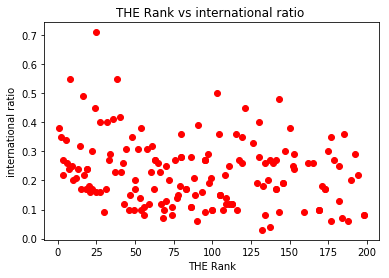

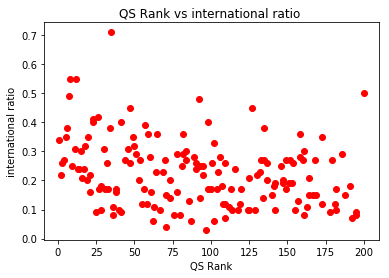

In [26]:
finalcopy=finalcopy.dropna(axis=0)
plt.figure()
plt.plot(finalcopy['THE Rank'],finalcopy['THE Quota of Int. Students'],'ro')
plt.title("THE Rank vs international ratio ")
plt.xlabel("THE Rank")
plt.ylabel("international ratio")
plt.show()
plt.figure()
plt.title("QS Rank vs international ratio ")
plt.plot(finalcopy['QS Rank'],finalcopy['THE Quota of Int. Students'],'ro')
plt.xlabel("QS Rank")
plt.ylabel("international ratio")
plt.show()



plot rank vs student to staff ratio

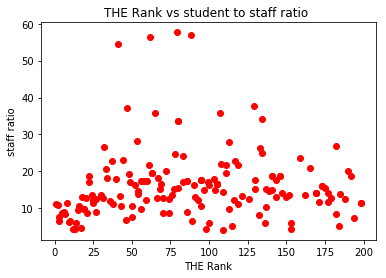

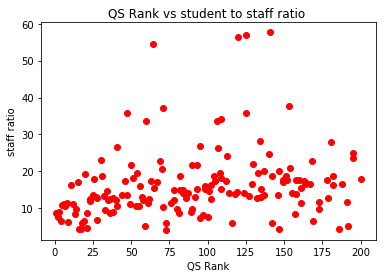

In [27]:
plt.figure()
plt.plot(finalcopy['THE Rank'],finalcopy['Student To Staff Ratio'],'ro')
plt.title("THE Rank vs student to staff ratio ")
plt.xlabel("THE Rank")
plt.ylabel("staff ratio")
plt.show()
plt.figure()
plt.title("QS Rank vs student to staff ratio ")
plt.plot(finalcopy['QS Rank'],finalcopy['Student To Staff Ratio'],'ro')
plt.xlabel("QS Rank")
plt.ylabel("staff ratio")
plt.show()

plot rank vs international staff ratio

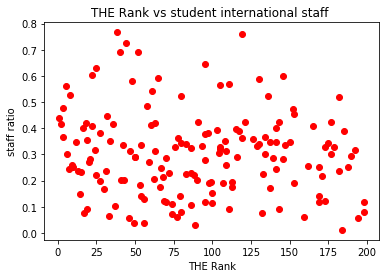

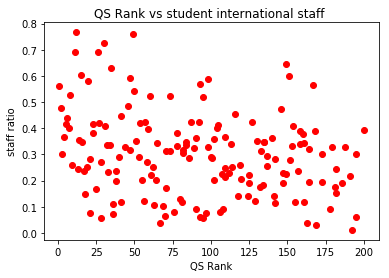

In [28]:
plt.figure()
plt.plot(finalcopy['THE Rank'],np.array(finalcopy['International Staff'])/np.array(finalcopy['QS Total Staff']),'ro')
plt.title("THE Rank vs student international staff ")
plt.xlabel("THE Rank")
plt.ylabel("staff ratio")
plt.show()

plt.figure()
plt.plot(finalcopy['QS Rank'],np.array(finalcopy['International Staff'])/np.array(finalcopy['QS Total Staff']),'ro')
plt.title("QS Rank vs student international staff ")
plt.xlabel("QS Rank")
plt.ylabel("staff ratio")
plt.show()



Look the the end of exercise for an interesting analysis of the difference in ranking.

**5. Best University**

To find the best university of the both rankings we are taking the average of both rankings and then sorting this number. If we had more information about how the rankings were made we could take a more funded approach.

In [29]:
#Adding column with average of 2 rankings 
#in case of conflict the QS ranking is used (because this one ranks EPFL higher and therefore is better)

finalcopy['averageRankings']=(np.array(finalcopy['THE Rank']).astype(float)+np.array(finalcopy['QS Rank']).astype(float))/2
#Sorting it
finalcopy=finalcopy.sort_values(['averageRankings','QS Rank'])
#Put the final rank in front (ascending according to the range)
finalcopy.insert(0, 'Final Rank', range(1, len(finalcopy)+1))

In [30]:
cleanDf=finalcopy.reset_index(drop=True)

In [31]:
#Make a more presenting dataframe by putting the average and the final ranking in front
cols=list(cleanDf.columns)
cols.insert(1, cols[-1])
cols = cols[:-1]
cleanDf=cleanDf[cols]
cleanDf

,Final Rank,averageRankings,Institution Name,QS Rank,Country,Region,QS Total Staff,QS Total Students,International Staff,International Students,Location,THE Rank,THE Total Students,Student To Staff Ratio,THE Quota of Int. Students
0,1,2.5,Stanford University,2,United States,North America,4285,15878,2042,3611,United States,3,15845,7.5,0.22
1,2,3.0,Massachusetts Institute of Technology,1,United States,North America,2982,11067,1679,3717,United States,5,11177,8.7,0.34
2,3,3.5,California Institute of Technology,4,United States,North America,953,2255,350,647,United States,3,2209,6.5,0.27
3,4,3.5,University of Cambridge,5,United Kingdom,Europe,5490,18770,2278,6699,United Kingdom,2,18389,10.9,0.35
4,5,3.5,University of Oxford,6,United Kingdom,Europe,6750,19720,2964,7353,United Kingdom,1,20409,11.2,0.38
5,6,4.5,Harvard University,3,United States,North America,4350,22429,1311,5266,United States,6,20326,8.9,0.26
6,7,8.0,Imperial College London,8,United Kingdom,Europe,3930,16090,2071,8746,United Kingdom,8,15857,11.4,0.55
7,8,9.0,University of Chicago,9,United States,North America,2449,13557,635,3379,United States,9,13525,6.2,0.25
8,9,10.0,Princeton University,13,United States,North America,1007,8069,246,1793,United States,7,7955,8.3,0.24
9,10,11.5,University College London,7,United Kingdom,Europe,6345,31080,2554,14854,United Kingdom,16,30304,10.5,0.49


Now we are going to plot the difference vs our ranking.

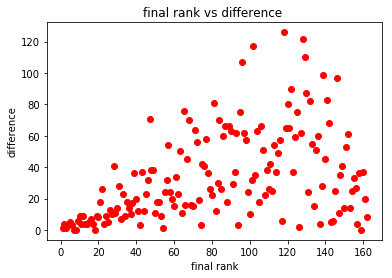

In [34]:
difference=np.abs(np.array(cleanDf["QS Rank"]).astype(float)-cleanDf["THE Rank"].astype(float))
plt.figure()
plt.plot(cleanDf['Final Rank'],list(difference),'ro')
plt.title("final rank vs difference ")
plt.xlabel("final rank")
plt.ylabel("difference")
plt.show()

The top 20 universities in our ranking show far less difference between the QS and the THE ranking than the rest. We can observe rise in difference further down the rankings. This might also indicate that more specialized universities are judged very differently, since might over perform in certain rankings while they're underepresented in other rankings.